# Bill Cobb's Vehicle Dynamics Professionals' July 2024 Challenge - #3

Given the results of a constant radius understeer test and various speed increments, compute the understeer gradient and cornering compliance evolution with lateral acceleration. The vehicle is a generic car with non-linear steering and non-linear tires simulated with Bill Cobb's BZ3 simulation program.


In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp

In [3]:
plt.style.use("seaborn-v0_8")

## Part 1: Define constants

We are given known quantities of the vehicle under test. Define them as constants.


In [4]:
VEHICLE_WB = 2.745  # m
VEHICLE_SR = 20.0  # rad/rad
VEHICLE_WF = 1000  # kg
VEHICLE_WR = 600  # kg
VEHICLE_M = VEHICLE_WF + VEHICLE_WR
VEHICLE_LA = VEHICLE_WB * (VEHICLE_WR / VEHICLE_M)
VEHICLE_LB = VEHICLE_WB * (VEHICLE_WF / VEHICLE_M)

Use constants for column header names to make it easier to access.


In [5]:
# Provided columns
COLUMN_TIME = "TIME, sec"
COLUMN_LATACC = "LATACC, g"
COLUMN_RUN = "RUN, RUN"
COLUMN_BETA = "SIDSLP, deg"
COLUMN_SPEED = "SPEED, kph"
COLUMN_STEER = "STEER, deg"
COLUMN_YAWVEL = "YAWVEL, deg/sec"

# Computed columns
COLUMN_LATACC_SI = "LATACC, m/s^2"
COLUMN_BETA_SI = "BETA, rad"
COLUMN_SPEED_SI = "SPEED, m/s"
COLUMN_STEER_SI = "STEER, rad"
COLUMN_DELTA = "DELTA, deg"
COLUMN_DELTA_SI = "DELTA, rad"
COLUMN_YAWVEL_SI = "YAWVEL, rad/sec"

# Math channels
COLUMN_DF = "DF, rad/G"
COLUMN_DR = "DR, rad/G"
COLUMN_USG = "USG, rad/G"

Define common conversion factors.


In [6]:
STD_G = 9.81
DEG2RAD = np.pi / 180.0
RAD2DEG = 1 / DEG2RAD
KPH2MPS = 1000 / 3600.0
MPS2KPH = 1 / KPH2MPS
M2FT = 3.28084

## Part 1: Data Wrangling


### Load in the data


Read in the data and sanitize it for consumption. The data has the following form:

| Row number | Description                                                                       | Sample                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| ---------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Line 1     | Comment header describing the contents of the CSV and relevant vehicle parameters | `"BZ3 Nonlinear Vehicle Dynamics Simulation SR= 20.00 WB=2745 mm  SR=20.00  WF=1000  WR=600"`                                                                                                                                                                                                                                                                                                                                           |
| Line 2     | Column header names and units                                                     | `"TIME, sec";"LATACC, g";"RUN, RUN";"SIDSLP, deg";"SPEED, kph";"STEER, deg";"YAWVEL, deg/sec";                                                                                                                                                                                                                                                                                                                                       ;` |
| Line 3+    | Time series data                                                                  | `1.080    ;0.412    ;14.000   ;-0.498   ;85.000   ;32.611   ;9.702     `                                                                                                                                                                                                                                                                                                                                                                |


In [7]:
FILE_PATH = "../data/marc3.txt"

In [8]:
df = pl.read_csv(FILE_PATH, skip_rows=1, columns=range(7), separator=";").with_columns(
    pl.col("*").str.extract(r"(^-?\d+[.\d]*)").str.to_decimal()
)
df

"TIME, sec","LATACC, g","RUN, RUN","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]"
0.000,0.282,1.000,0.000,20.000,31.000,0.000
0.010,0.208,1.000,0.233,20.000,31.000,0.752
0.020,0.153,1.000,0.397,20.000,31.000,1.300
0.030,0.116,1.000,0.512,20.000,31.000,1.700
0.040,0.090,1.000,0.593,20.000,31.000,1.995
…,…,…,…,…,…,…
9.960,0.748,17.000,-1.742,100.000,45.157,15.135
9.970,0.748,17.000,-1.742,100.000,45.157,15.135
9.980,0.748,17.000,-1.742,100.000,45.157,15.135


### Convert to SI units

Perform all calculations in SI units.


In [9]:
df = df.with_columns(
    (pl.col(COLUMN_LATACC).cast(pl.Float32) * STD_G).alias(COLUMN_LATACC_SI),
    (pl.col(COLUMN_BETA).cast(pl.Float32) * DEG2RAD).alias(COLUMN_BETA_SI),
    (pl.col(COLUMN_SPEED).cast(pl.Float32) * KPH2MPS).alias(COLUMN_SPEED_SI),
    (pl.col(COLUMN_STEER).cast(pl.Float32) * DEG2RAD).alias(COLUMN_STEER_SI),
    (pl.col(COLUMN_YAWVEL).cast(pl.Float32) * DEG2RAD).alias(COLUMN_YAWVEL_SI),
    (pl.col(COLUMN_STEER).cast(pl.Float32) / VEHICLE_SR).alias(COLUMN_DELTA),
    (pl.col(COLUMN_STEER).cast(pl.Float32) * DEG2RAD / VEHICLE_SR).alias(
        COLUMN_DELTA_SI
    ),
)
df

"TIME, sec","LATACC, g","RUN, RUN","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","YAWVEL, rad/sec","DELTA, deg","DELTA, rad"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32
0.000,0.282,1.000,0.000,20.000,31.000,0.000,2.76642,0.0,5.555556,0.541052,0.0,1.55,0.027053
0.010,0.208,1.000,0.233,20.000,31.000,0.752,2.04048,0.004067,5.555556,0.541052,0.013125,1.55,0.027053
0.020,0.153,1.000,0.397,20.000,31.000,1.300,1.50093,0.006929,5.555556,0.541052,0.022689,1.55,0.027053
0.030,0.116,1.000,0.512,20.000,31.000,1.700,1.13796,0.008936,5.555556,0.541052,0.029671,1.55,0.027053
0.040,0.090,1.000,0.593,20.000,31.000,1.995,0.8829,0.01035,5.555556,0.541052,0.034819,1.55,0.027053
…,…,…,…,…,…,…,…,…,…,…,…,…,…
9.960,0.748,17.000,-1.742,100.000,45.157,15.135,7.337881,-0.030404,27.777779,0.788138,0.264156,2.25785,0.039407
9.970,0.748,17.000,-1.742,100.000,45.157,15.135,7.337881,-0.030404,27.777779,0.788138,0.264156,2.25785,0.039407
9.980,0.748,17.000,-1.742,100.000,45.157,15.135,7.337881,-0.030404,27.777779,0.788138,0.264156,2.25785,0.039407


### Visualize provided data

Plot the timeseries to see what we are working with.


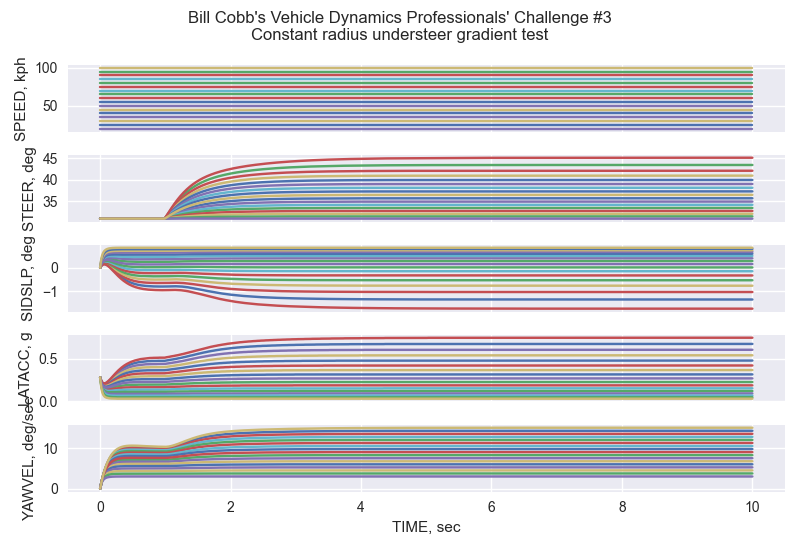

In [10]:
fig, axes = plt.subplots(5, 1, sharex=True)

# Plot
columns = [COLUMN_SPEED, COLUMN_STEER, COLUMN_BETA, COLUMN_LATACC, COLUMN_YAWVEL]
for ax, col in zip(axes, columns):
    for name, data in df.group_by(COLUMN_RUN):
        ax.plot(data[COLUMN_TIME], data[col], label=f"Run {name}")
    ax.set_ylabel(col)

# Labels
axes[-1].set_xlabel(COLUMN_TIME)

# Title
fig.suptitle(
    "Bill Cobb's Vehicle Dynamics Professionals' Challenge #3\nConstant radius understeer gradient test"
)

plt.tight_layout()
plt.show()

## Part 2: Data exploration

Given that this is a constant radius test, what is the radius of the skidpad?


### Extract the steady-state response from each run


In [11]:
# Steady-state dataframe (sdf)
sdf = df.group_by(COLUMN_RUN).tail(1).sort(by=COLUMN_SPEED)
sdf

"RUN, RUN","TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","YAWVEL, rad/sec","DELTA, deg","DELTA, rad"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32
1.000,10.000,0.030,0.850,20.000,30.980,3.027,0.2943,0.014835,5.555556,0.540703,0.052831,1.549,0.027035
2.000,10.000,0.047,0.803,25.000,31.516,3.784,0.46107,0.014015,6.944445,0.550058,0.066043,1.5758,0.027503
3.000,10.000,0.067,0.744,30.000,32.122,4.540,0.65727,0.012985,8.333334,0.560635,0.079238,1.6061,0.028032
4.000,10.000,0.092,0.675,35.000,32.780,5.297,0.90252,0.011781,9.722222,0.572119,0.09245,1.639,0.028606
5.000,10.000,0.120,0.595,40.000,33.477,6.054,1.1772,0.010385,11.111112,0.584284,0.105662,1.67385,0.029214
…,…,…,…,…,…,…,…,…,…,…,…,…,…
13.000,10.000,0.479,-0.533,80.000,39.979,12.108,4.69899,-0.009303,22.222223,0.697765,0.211324,1.99895,0.034888
14.000,10.000,0.541,-0.765,85.000,40.991,12.865,5.30721,-0.013352,23.611113,0.715428,0.224537,2.04955,0.035771
15.000,10.000,0.606,-1.034,90.000,42.129,13.621,5.94486,-0.018047,25.000002,0.73529,0.237731,2.10645,0.036764


### Calculate the skidpad radius from the steady-state responses

Use the following relationship to compute corner radius.

$$ u = \omega R $$


In [12]:
radius = (sdf[COLUMN_SPEED_SI] / sdf[COLUMN_YAWVEL_SI]).median()
print(f"Skidpad radius is: {radius:.2f} m")
print(f"Skidpad radius is: {radius * M2FT:.2f} ft")

Skidpad radius is: 105.16 m
Skidpad radius is: 345.00 ft


## Part 3: Extract metrics

From a constant radius understeer gradient test, we can compute the understeer gradient from the measured steering response and the rear cornering compliance from the measured sideslip response.


### Helper functions

Place boilerplate reusable code before we begin our computation.


In [13]:
def gradient(x, y, s=0.0):
    """Compute gradients by fitting a smoothing spline to the data."""
    f = sp.interpolate.splrep(x, y, s=s)
    return sp.interpolate.splev(x, f, der=1)


def interpolate(x, y, xeval):
    """Interpolate x and y at xeval"""
    f = sp.interpolate.CubicSpline(x, y)
    return f(xeval) 

### Understeer gradient

The understeer gradient is a gain on lateral acceleration that modifies the required road wheel angle to meet a specified corner radius. Recall:

$$ \delta = \frac{L}{R} + Ka_y $$

Where

- $\delta$ is the road wheel angle [rad]
- $L$ is the wheelbase [m]
- $R$ is the radius of the turn [m]
- $a_y$ is the lateral acceleration [m/s^2]
- $K$ is the understeer gradient [rad/m/s^2]

For math reasons, we change from using radius to curvature.

$$ \delta = L \kappa + Ka_y $$

In a constant curvature understeer gradient test, the road wheel angle $\delta$ and lateral acceleration $a_y$ are variable.

$$
d\delta = K da_y
$$

The understeer gradient is simply the gradient of the road wheel angle with respect to lateral acceleration.

$$
K = \frac{d\delta}{da_y}
$$


In [14]:
# With units of rad/G
smooth_factor = 0.001
sdf = sdf.with_columns(
    pl.Series(
        name=COLUMN_USG,
        values=gradient(sdf[COLUMN_LATACC], sdf[COLUMN_DELTA_SI], s=smooth_factor),
    )
)
sdf

"RUN, RUN","TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","YAWVEL, rad/sec","DELTA, deg","DELTA, rad","USG, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32,f64
1.000,10.000,0.030,0.850,20.000,30.980,3.027,0.2943,0.014835,5.555556,0.540703,0.052831,1.549,0.027035,0.026037
2.000,10.000,0.047,0.803,25.000,31.516,3.784,0.46107,0.014015,6.944445,0.550058,0.066043,1.5758,0.027503,0.025005
3.000,10.000,0.067,0.744,30.000,32.122,4.540,0.65727,0.012985,8.333334,0.560635,0.079238,1.6061,0.028032,0.02385
4.000,10.000,0.092,0.675,35.000,32.780,5.297,0.90252,0.011781,9.722222,0.572119,0.09245,1.639,0.028606,0.022493
5.000,10.000,0.120,0.595,40.000,33.477,6.054,1.1772,0.010385,11.111112,0.584284,0.105662,1.67385,0.029214,0.021088
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
13.000,10.000,0.479,-0.533,80.000,39.979,12.108,4.69899,-0.009303,22.222223,0.697765,0.211324,1.99895,0.034888,0.013912
14.000,10.000,0.541,-0.765,85.000,40.991,12.865,5.30721,-0.013352,23.611113,0.715428,0.224537,2.04955,0.035771,0.014706
15.000,10.000,0.606,-1.034,90.000,42.129,13.621,5.94486,-0.018047,25.000002,0.73529,0.237731,2.10645,0.036764,0.016183


### Rear cornering compliance

From first principles, cornering compliance is the steady-state change in slip
angle with respect to lateral acceleration.

$$ D = -\frac{d\alpha}{da_y}$$

The slip angle of the rear axle in steady-state is the summation of the side
slip angle $\beta$ and the geometric component induced by the yaw velocity.
Assuming in SAE J670 coordinates.

$$ \alpha_r = \beta - \frac{l_b a_y}{u^2} $$

or...

$$ \alpha_r = \beta - \frac{l_b \kappa a_y}{u} $$

Implicitly differentiate assuming curvature, $\kappa$, is constant.

$$ d\alpha_r = d\beta - \frac{l_b d\kappa da_y}{du} $$
$$ D_r = -\frac{d\beta}{da_y} $$

In [15]:
# With units rad/G
smooth_factor = 0.001
sdf = sdf.with_columns(
    pl.Series(
        name=COLUMN_DR,
        values=-gradient(sdf[COLUMN_LATACC], sdf[COLUMN_BETA_SI], s=smooth_factor),
    )
)
sdf

"RUN, RUN","TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","YAWVEL, rad/sec","DELTA, deg","DELTA, rad","USG, rad/G","DR, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32,f64,f64
1.000,10.000,0.030,0.850,20.000,30.980,3.027,0.2943,0.014835,5.555556,0.540703,0.052831,1.549,0.027035,0.026037,0.052095
2.000,10.000,0.047,0.803,25.000,31.516,3.784,0.46107,0.014015,6.944445,0.550058,0.066043,1.5758,0.027503,0.025005,0.051622
3.000,10.000,0.067,0.744,30.000,32.122,4.540,0.65727,0.012985,8.333334,0.560635,0.079238,1.6061,0.028032,0.02385,0.051157
4.000,10.000,0.092,0.675,35.000,32.780,5.297,0.90252,0.011781,9.722222,0.572119,0.09245,1.639,0.028606,0.022493,0.050719
5.000,10.000,0.120,0.595,40.000,33.477,6.054,1.1772,0.010385,11.111112,0.584284,0.105662,1.67385,0.029214,0.021088,0.050414
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
13.000,10.000,0.479,-0.533,80.000,39.979,12.108,4.69899,-0.009303,22.222223,0.697765,0.211324,1.99895,0.034888,0.013912,0.064019
14.000,10.000,0.541,-0.765,85.000,40.991,12.865,5.30721,-0.013352,23.611113,0.715428,0.224537,2.04955,0.035771,0.014706,0.069657
15.000,10.000,0.606,-1.034,90.000,42.129,13.621,5.94486,-0.018047,25.000002,0.73529,0.237731,2.10645,0.036764,0.016183,0.076608


### Front cornering compliance

Recall that the understeer gradient is the difference between front and rear cornering compliances.

$$ K = D_f - D_r $$

Therefore.

$$ D_f = D_r + K $$


In [16]:
sdf = sdf.with_columns((pl.col(COLUMN_DR) + pl.col(COLUMN_USG)).alias(COLUMN_DF))
sdf

"RUN, RUN","TIME, sec","LATACC, g","SIDSLP, deg","SPEED, kph","STEER, deg","YAWVEL, deg/sec","LATACC, m/s^2","BETA, rad","SPEED, m/s","STEER, rad","YAWVEL, rad/sec","DELTA, deg","DELTA, rad","USG, rad/G","DR, rad/G","DF, rad/G"
"decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]","decimal[*,3]",f32,f32,f32,f32,f32,f32,f32,f64,f64,f64
1.000,10.000,0.030,0.850,20.000,30.980,3.027,0.2943,0.014835,5.555556,0.540703,0.052831,1.549,0.027035,0.026037,0.052095,0.078132
2.000,10.000,0.047,0.803,25.000,31.516,3.784,0.46107,0.014015,6.944445,0.550058,0.066043,1.5758,0.027503,0.025005,0.051622,0.076627
3.000,10.000,0.067,0.744,30.000,32.122,4.540,0.65727,0.012985,8.333334,0.560635,0.079238,1.6061,0.028032,0.02385,0.051157,0.075007
4.000,10.000,0.092,0.675,35.000,32.780,5.297,0.90252,0.011781,9.722222,0.572119,0.09245,1.639,0.028606,0.022493,0.050719,0.073211
5.000,10.000,0.120,0.595,40.000,33.477,6.054,1.1772,0.010385,11.111112,0.584284,0.105662,1.67385,0.029214,0.021088,0.050414,0.071503
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
13.000,10.000,0.479,-0.533,80.000,39.979,12.108,4.69899,-0.009303,22.222223,0.697765,0.211324,1.99895,0.034888,0.013912,0.064019,0.07793
14.000,10.000,0.541,-0.765,85.000,40.991,12.865,5.30721,-0.013352,23.611113,0.715428,0.224537,2.04955,0.035771,0.014706,0.069657,0.084363
15.000,10.000,0.606,-1.034,90.000,42.129,13.621,5.94486,-0.018047,25.000002,0.73529,0.237731,2.10645,0.036764,0.016183,0.076608,0.092791


### Tangent speed

The tangent speed is the speed at which the steady-state chassis sideslip angle becomes zero.


In [17]:
stdf = sdf.filter(pl.col(COLUMN_BETA).is_between(-1, 1)).sort(by=COLUMN_BETA)
tangent_speed = interpolate(stdf[COLUMN_BETA_SI], stdf[COLUMN_SPEED_SI], 0)
print(f"Tangent speed: {tangent_speed:.2f} m/s")
print(f"Tangent speed: {tangent_speed*MPS2KPH:.2f} km/h")

Tangent speed: 18.16 m/s
Tangent speed: 65.39 km/h


## Part 4: Visualize

Plot all the results into a figure and present the results.


In [18]:
FIG_SCALE = 0.8

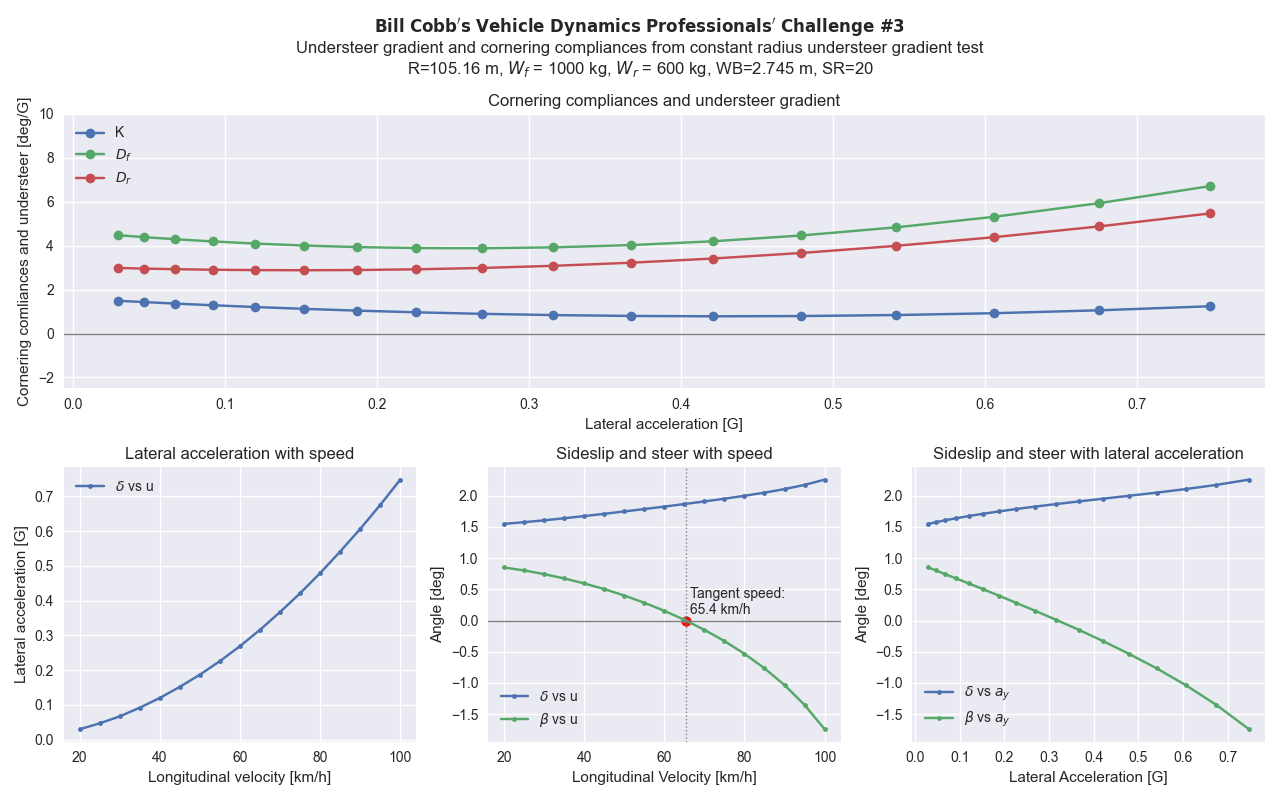

In [20]:
# Setup figure
fig = plt.figure(figsize=(16 * FIG_SCALE, 10 * FIG_SCALE))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])

# Axis - compliances vs. acceleration
ax1.plot(
    sdf[COLUMN_LATACC],
    sdf[COLUMN_USG, COLUMN_DF, COLUMN_DR] * RAD2DEG,
    marker="o",
    label=[r"K", r"$D_f$", r"$D_r$"],
)
ax1.axhline(0, color="gray", linewidth=1, linestyle="-")
ax1.set_title("Cornering compliances and understeer gradient")
ax1.set_ylabel("Cornering comliances and understeer [deg/G]")
ax1.set_xlabel("Lateral acceleration [G]")
ax1.set_ylim(bottom=-2.5, top=10)
ax1.legend()

# Axis - steer and chassis sideslip vs. speed
ax3.plot(
    sdf[COLUMN_SPEED],
    sdf[COLUMN_DELTA, COLUMN_BETA],
    marker=".",
    label=[r"$\delta$ vs u", r"$\beta$ vs u"],
)
ax3.scatter(tangent_speed*MPS2KPH, 0, color="red")
ax3.axhline(0, color="gray", linewidth=1, linestyle="-")
ax3.axvline(tangent_speed*MPS2KPH, color="gray", linewidth=1, linestyle="dotted")
ax3.annotate(
    f"Tangent speed:\n{tangent_speed*MPS2KPH:.1f} km/h",
    xy=(tangent_speed*MPS2KPH+1, 0+0.1),
)
ax3.set_title("Sideslip and steer with speed")
ax3.set_ylabel("Angle [deg]")
ax3.set_xlabel("Longitudinal Velocity [km/h]")
ax3.legend()

# Axis - steering and sideslip vs latg
ax4.plot(sdf[COLUMN_LATACC], sdf[COLUMN_DELTA], marker=".", label=r"$\delta$ vs $a_y$")
ax4.plot(sdf[COLUMN_LATACC], sdf[COLUMN_BETA], marker=".", label=r"$\beta$ vs $a_y$")
ax4.set_title("Sideslip and steer with lateral acceleration")
ax4.set_xlabel("Lateral Acceleration [G]")
ax4.set_ylabel(r"Angle [deg]")
ax4.legend()

# Axis - steering and sideslip vs speed
ax2.plot(sdf[COLUMN_SPEED], sdf[COLUMN_LATACC], marker=".", label=r"$\delta$ vs u")
ax2.set_title("Lateral acceleration with speed")
ax2.set_xlabel("Longitudinal velocity [km/h]")
ax2.set_ylabel(r"Lateral acceleration [G]")
ax2.legend()


# Global title
plt.suptitle(
    r"$\mathbf{Bill\ Cobb's\ Vehicle\ Dynamics\ Professionals'\ Challenge\ \#3}$"
    + "\n"
    + "Understeer gradient and cornering compliances from constant radius understeer gradient test"
    + "\n"
    + f"R={radius:.2f} m, "
    + r"$W_f$ = 1000 kg, $W_r$ = 600 kg, WB=2.745 m, SR=20"
)

fig.tight_layout()
plt.show()